In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from utils import get_ts
from warnings import simplefilter
simplefilter("ignore")

In [7]:
df = get_ts(days="max")

In [8]:
df.head()

,prices
dates,
2018-05-03,0.179034
2018-05-04,0.197912
2018-05-05,0.219618
2018-05-06,0.229286
2018-05-07,0.229286


In [9]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [20]:
df.index = pd.DatetimeIndex(df.index)

,prices
dates,
2019-04-28,0.070732
2019-04-29,0.072836
2019-04-30,0.072134
2019-05-01,0.070989
2019-05-02,0.073829
...,...
2021-10-17,1.527458
2021-10-18,1.453869
2021-10-19,1.495642


In [34]:
df_3years = df.iloc[-365*3:]

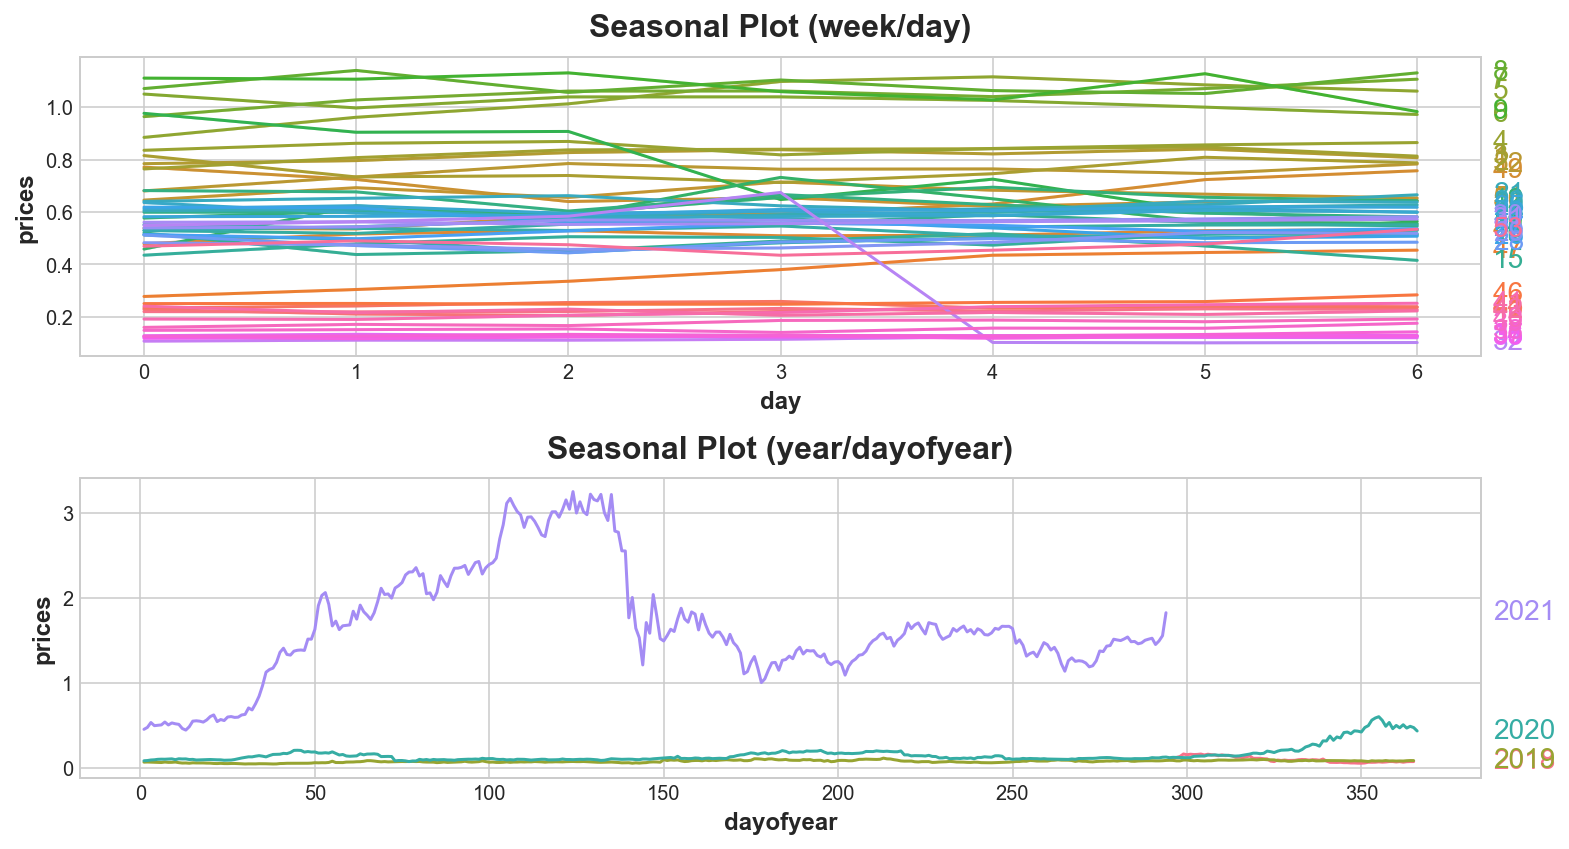

In [39]:
X = df_3years.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="prices", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="prices", period="year", freq="dayofyear", ax=ax1)
plt.show()

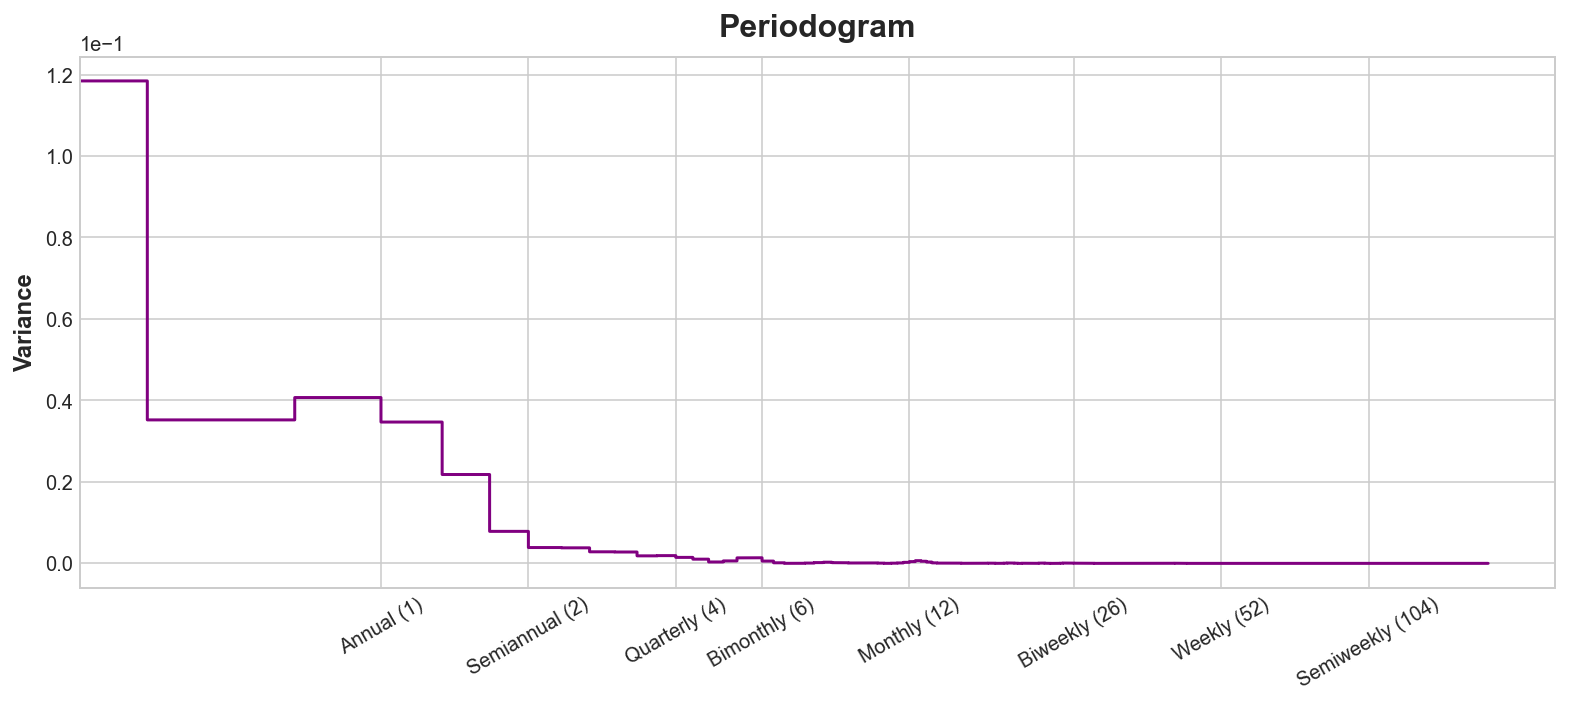

In [36]:
plot_periodogram(df_3years.prices);

Indicators and fourier features won't be very helpful. Indicators show hardly anything in weekdays. In the periodogram we see a drop of variance at 'semiannual' fouriers. Don't know if this would help. Here we'll continue with NEXO. However, we may try other cryptos as well. If there's no seasonality, modeling might be challenging. It might by necessary to switch to something else.

In [48]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=6)  # 6 sin/cos pairs for "A"nnual seasonality
# semiannual (2) + quarterly (4) ~ 6 sin/cos pairs per year


dp = DeterministicProcess(
    index=df_3years.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample() 
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)","sin(5,freq=A-DEC)","cos(5,freq=A-DEC)","sin(6,freq=A-DEC)","cos(6,freq=A-DEC)"
dates,,,,,,,,,,,,,,,,,,,,
2018-10-23,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.933837,0.357698,-0.668064,-0.744104,0.455907,-0.890028,0.994218,0.107381,0.255353,0.966848,-0.811539,0.584298
2018-10-24,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.927542,0.373720,-0.693281,-0.720667,0.409356,-0.912375,0.999250,0.038722,0.337523,0.941317,-0.746972,0.664855
2018-10-25,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.920971,0.389630,-0.717677,-0.696376,0.361714,-0.932289,0.999546,-0.030120,0.417194,0.908818,-0.674444,0.738326
2018-10-26,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.914128,0.405426,-0.741222,-0.671260,0.313107,-0.949718,0.995105,-0.098820,0.493776,0.869589,-0.594727,0.803928
2018-10-27,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.907014,0.421101,-0.763889,-0.645348,0.263665,-0.964614,0.985948,-0.167052,0.566702,0.823923,-0.508671,0.860961


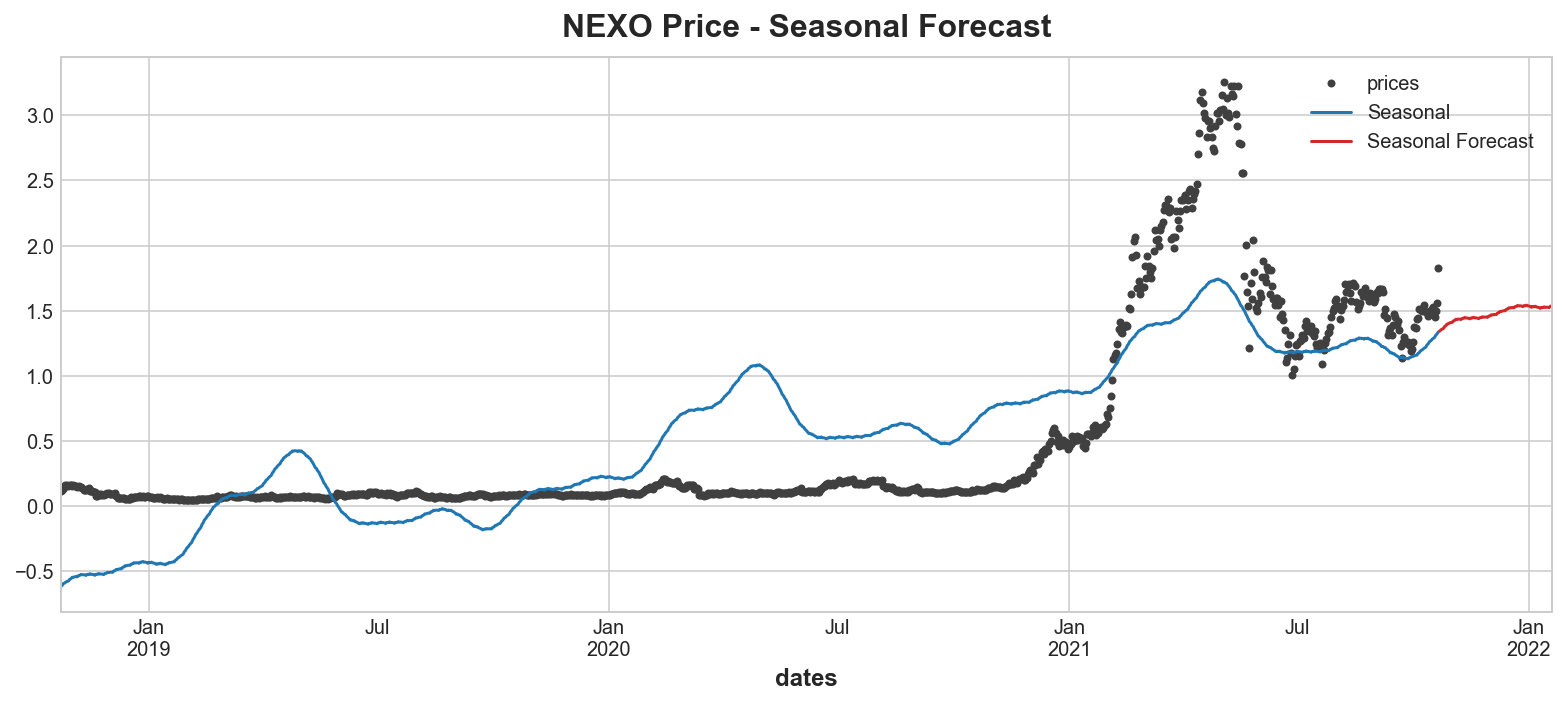

In [49]:
y = df_3years["prices"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)

forecast_n_days = 90
forecast_index = pd.date_range(df_3years.index.max(), periods=forecast_n_days+1).tolist()[1:]

X_fore = dp.out_of_sample(steps=forecast_n_days,forecast_index=forecast_index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="NEXO Price - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

From January 2021 on a seasonal model seems to do an acceptable job. I'm surprised. Maybe seasonal features can still be useful even if they're weak.

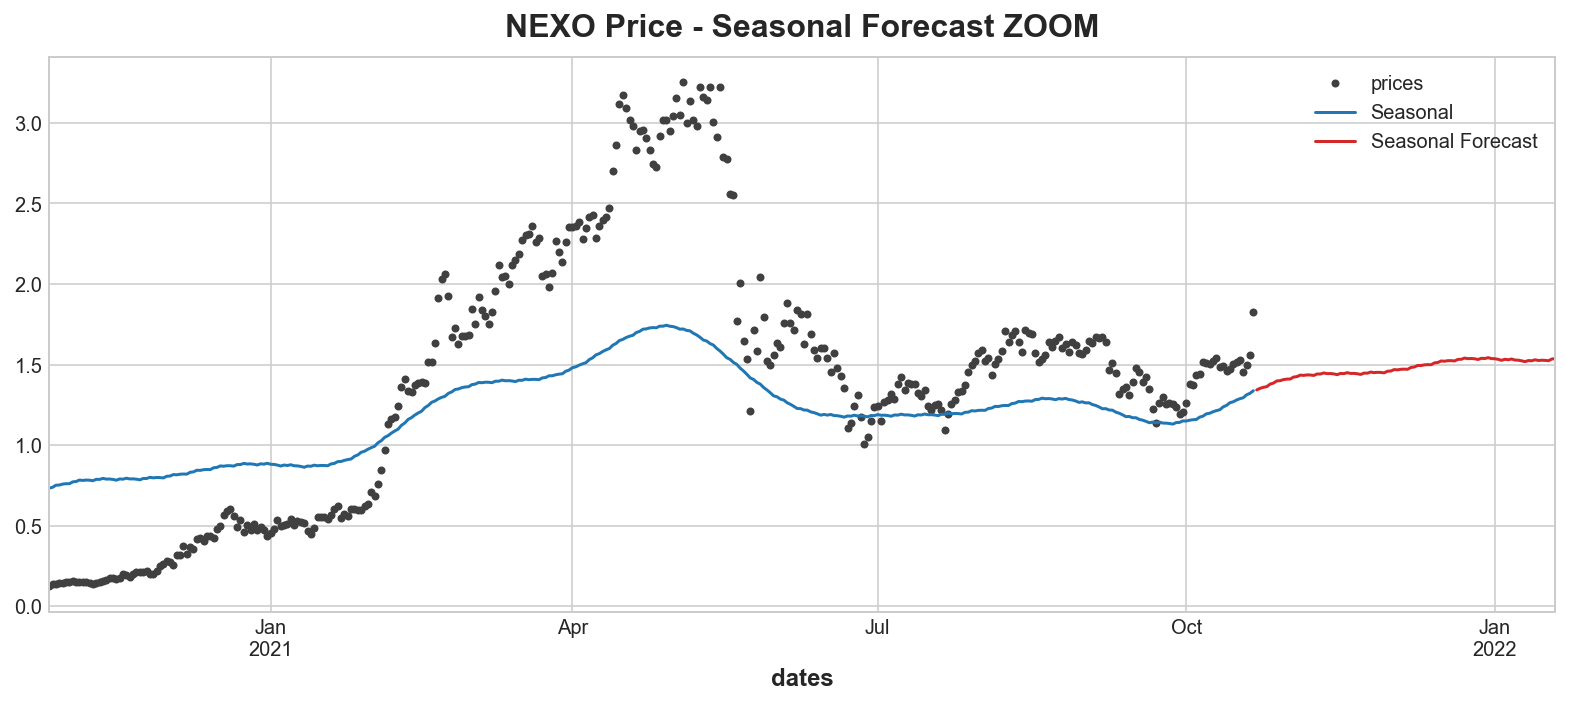

In [56]:
ax = y.iloc[-360:].plot(color='0.25', style='.', title="NEXO Price - Seasonal Forecast ZOOM")
ax = y_pred.iloc[-360:].plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

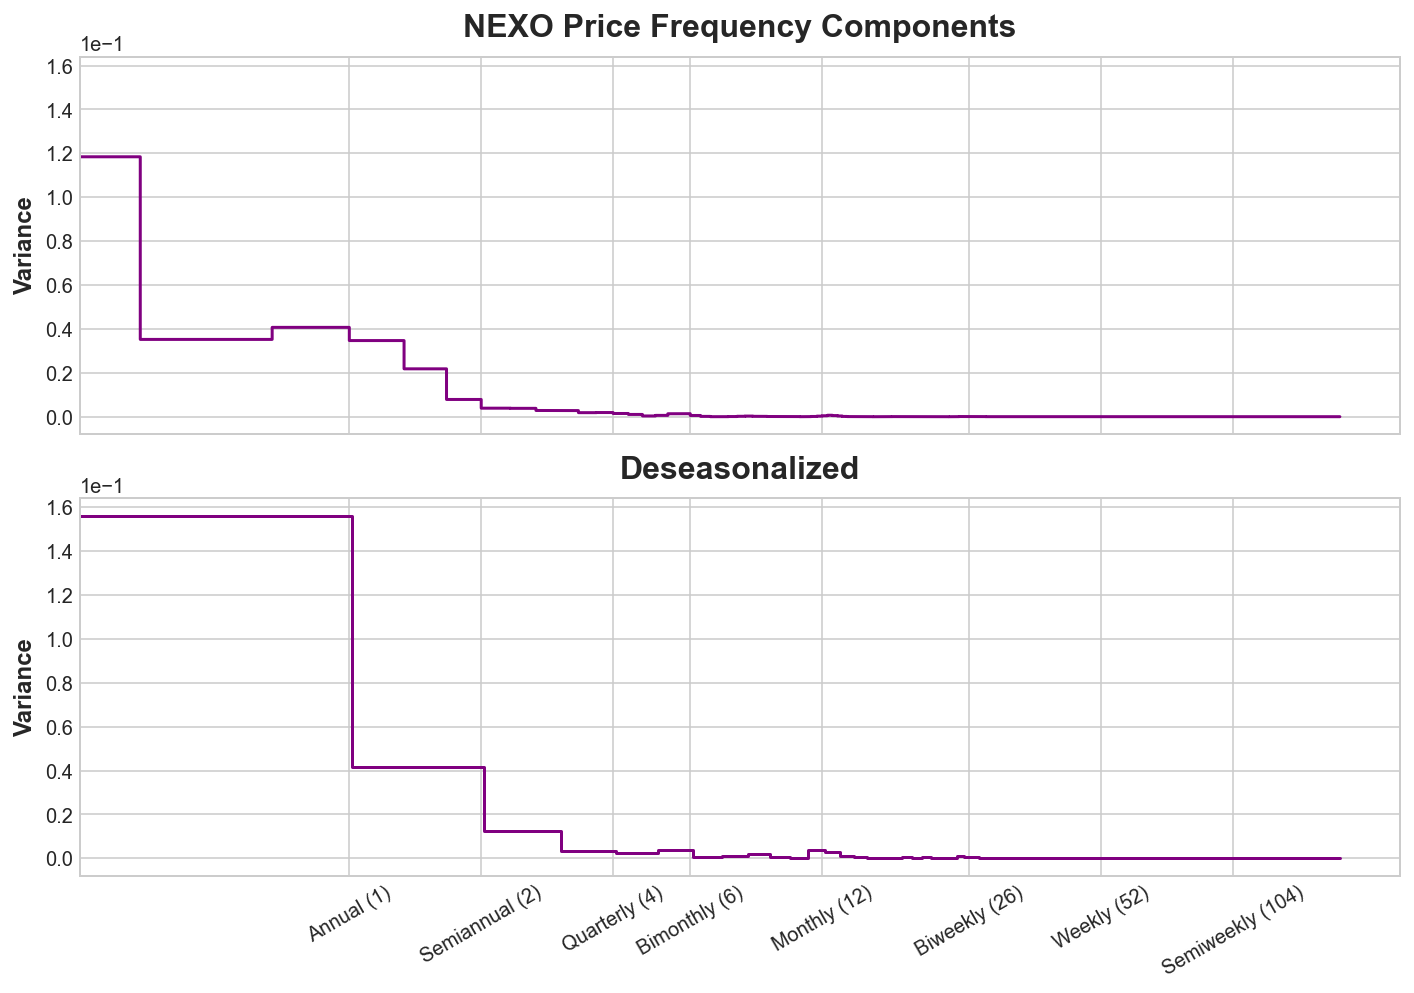

In [57]:
y_deseason = y.iloc[-360:] - y_pred.iloc[-360:]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("NEXO Price Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

And yet if we substract seasonality there are still large values left, which means that the model didn't learn seasonal effects in the price that well.